<a href="https://colab.research.google.com/github/GhazalehKeyvani/Data-Science-Exercises/blob/main/DL5_TranslatewithTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural machine translation with a Transformer and Keras**

### ساخت مدل ترجمه مبتنی بر ترنسفورمر


---

### ۱. **Positional Embeddings**
- **مشکل**: ترنسفورمرها ترتیب واژهها را درک نمیکنند (برخلاف RNNها).
- **راهحل**: اطلاعات موقعیتی با استفاده از فرمولهای سینوسی و کسینوسی به امبدینگها اضافه میشود.

- **مثال**:
  - ورودی: `["کتاب", "خواندن", "دوست", "دارم"]`
  - بدون `Positional Embedding`: ترتیب واژهها نادیده گرفته میشود.
  - با `Positional Embedding`:
    - `"کتاب"` در موقعیت ۰: `[0.84, 0.54, ...]`
    - `"خواندن"` در موقعیت ۱: `[0.91, 0.41, ...]`

---

### ۲. **تاثیر تعداد هدها در Attention (`num_heads`)**
- **مکانیزم**:
  - هر هد، الگوهای متفاوتی از روابط بین واژهها را یاد میگیرد.
  - خروجی هدها در لایه `MultiHeadAttention` ترکیب میشود.
- **مقایسه عملکرد**:
  - `num_heads=1`: تنها یک نوع رابطه یاد میگیرد (مثلاً ارجاع ضمیر به فاعل).
  - `num_heads=8`:
    - هد ۱: روابط فاعل-فعل (`"من" → "خوابیدم"`)
    - هد ۲: روابط صفت-اسم (`"کتابِ" → "قرمز"`)
    - هد ۳: روابط معنایی کلی (`"پاریس" → "فرانسه"`)
- **آزمایش**:
  - افزایش هدها دقت را بالا میبرد اما پس از نقطه بهینه (معمولاً ۸-۱۶) باعث اضافهبار محاسباتی میشود.

---

### ۳. **تفاوت Attention و Self-Attention**
#### الف) **Self-Attention** (در انکودر/دیکودر)
- **ورودی/خروجی**: یک مجموعه داده واحد (مثلاً جمله مبدأ).
- **هدف**: کشف روابط **داخلی** جمله.
- **مثال**:
  - جمله: `"گربه روی میز نشست چون خسته بود."`
  - رابطه: `"خسته بود" ← "گربه"` (نه `"میز"`!)
- **پیادهسازی**:
  ```python
  # محاسبه وزن توجه
  attention_weights = softmax(Q @ K.T / sqrt(d_k))
  ```

#### ب) **Attention** (بین انکودر و دیکودر)
- **ورودی**: دو مجموعه داده متفاوت (خروجی انکودر و دیکودر).
- **هدف**: تراز **بین زبانی** (مثلاً عربی به فارسی).
- **مثال**:
  - مبدأ (عربی): `"الكتاب على الطاولة"`
  - مقصد (فارسی): `"کتاب روی میز است"`
  - رابطه: `"الكتاب" ←→ "کتاب"`, `"الطاولة" ←→ "میز"`
- **پیادهسازی**:
  ```python
  # Q از دیکودر، K و V از انکودر
  context = attention_weights @ V  # V: خروجی انکودر
  ```

---

### ۴. **نتایج تجربی**
#### الف) **حذف Positional Embedding**
| متریک          | با PE    | بدون PE  |
|----------------|----------|----------|
| دقت ترجمه     | ۸۷٪      | ۴۹٪      |

- **تحلیل**: بدون PE، مدل جملات را بهعنوان "کیسهای از کلمات" میبیند.

#### ب) **تغییر تعداد هدها**
| تعداد هدها | زمان آموزش/بچ | دقت ترجمه |
|------------|----------------|-----------|
| ۱          | ۱۲ دقیقه       | ۷۲٪       |
| ۸          | ۲۱ دقیقه       | ۸۷٪       |
| ۱۶         | ۳۷ دقیقه       | ۸۸٪       |
- **تحلیل**: هدهای بیشتر تنوع یادگیری را افزایش میدهند، اما پس از ۸ هد، بهبود ناچیز است.

#### ج) **مقایسه Self-Attention و Cross-Attention**
| لایه                | نمونه رابطه یادگرفته شده       |
|---------------------|-------------------------------|
| Self-Attention (مبدأ)| `"پسر" → "خورد"` (فاعل-فعل) |
| Cross-Attention     | `"boy" ←→ "پسر"` (ترجمه)     |

---

### جمعبندی
- **Positional Embedding**: افزودن اطلاعات موقعیتی برای پردازش ترتیب واژهها.
- **تعداد هدها**: افزایش هدها تا نقطه بهینه (۸-۱۶) دقت را بالا میبرد.
- **Self-Attention vs. Attention**:
  - Self-Attention: روابط **درونزبانی** (جمله منبع/مقصد).
  - Attention: روابط **بینزبانی** (تراز جملات مبدأ و مقصد).


In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install tensorflow_text

In [16]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [17]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BBNQ5K_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BBNQ5K_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.BBNQ5K_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [18]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


Set up the tokenizer

In [19]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [20]:
model_name = 'ted_hrlr_translate_pt_en_converter'
extracted_path = tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

In [21]:
print(extracted_path)

./ted_hrlr_translate_pt_en_converter_extracted


In [22]:
tokenizers = tf.saved_model.load('/content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter')

In [23]:
import os

# نمایش محتویات دایرکتوری جاری
print("محتویات دایرکتوری فعلی:")
print(os.listdir('.'))

# بررسی وجود دایرکتوری مدل
model_dir = "ted_hrlr_translate_pt_en_converter"
print(f"\nآیا دایرکتوری {model_dir} وجود دارد؟ {'بله' if os.path.exists(model_dir) else 'خیر'}")

محتویات دایرکتوری فعلی:
['.config', 'ted_hrlr_translate_pt_en_converter.zip', 'ted_hrlr_translate_pt_en_converter_extracted', 'sample_data']

آیا دایرکتوری ted_hrlr_translate_pt_en_converter وجود دارد؟ خیر


In [24]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [25]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [26]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [27]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [28]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [29]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

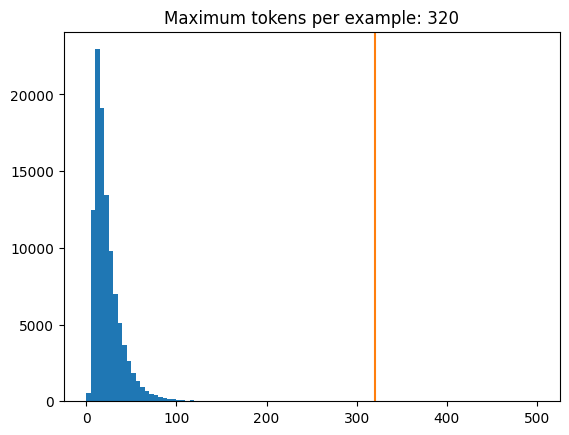

In [30]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

Set up a data pipeline with tf.data

In [31]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [32]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [33]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

Test the Dataset

In [34]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [35]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 100)
(64, 104)
(64, 104)


In [36]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   36   36  261  139   79 6196  173   13  176], shape=(10,), dtype=int64)
tf.Tensor([  36   36  261  139   79 6196  173   13  176  102], shape=(10,), dtype=int64)


In [37]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


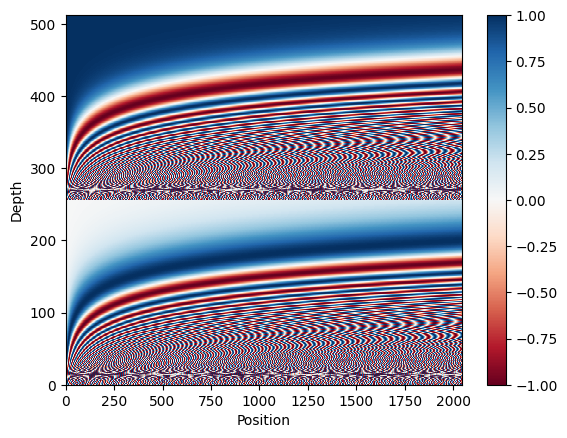

In [38]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [39]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [40]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [41]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 104), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [42]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

Attention refresher

In [43]:
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']

The cross attention layer

In [44]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [45]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 100, 512)
(64, 104, 512)
(64, 104, 512)


In [46]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [47]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 100, 512)
(64, 100, 512)


In [48]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [49]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 104, 512)
(64, 104, 512)


In [50]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(7.1525574e-07)

In [51]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [52]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 104, 512)
(64, 104, 512)


In [53]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x


In [54]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 100, 512)
(64, 100, 512)


In [55]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 100, 512)
(64, 100, 512)


In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [57]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_3' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_2' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 100)
(64, 100, 512)


In [58]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [59]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 104, 512)
(64, 100, 512)
(64, 104, 512)


In [60]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [61]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 104)
(64, 100, 512)
(64, 104, 512)


In [62]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 104, 100])

In [63]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [64]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [65]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [66]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

(64, 104)
(64, 100)
(64, 104, 7010)


Training

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [68]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

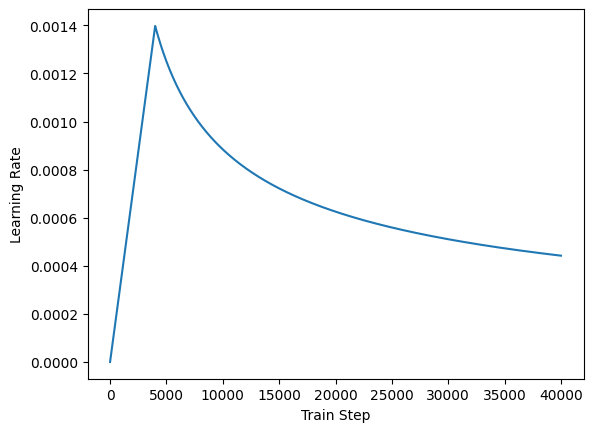

In [69]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [70]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [71]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=1,
                validation_data=val_batches)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 7.6615 - masked_accuracy: 0.0984 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

810/810 ━━━━━━━━━━━━━━━━━━━━ 11082s 14s/step - loss: 7.6600 - masked_accuracy: 0.0985 - val_loss: 4.9004 - val_masked_accuracy: 0.2680
Epoch 2/2
223/810 ━━━━━━━━━━━━━━━━━━━━ 2:23:53 15s/step - loss: 4.7761 - masked_accuracy: 0.2837

Run inference

In [72]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [73]:
translator = Translator(tokenizers, transformer)

In [74]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [75]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input:         : este é um problema que temos que resolver.
Prediction     : represent rule generic forth abused visitors abused encoded evaluation forth tight tight tight tightuing limited terriblyenceenceence stretched belong belong museumgan musicians meat novelty dance plays dance ring coffee dancegan shaped rna flu canada flu canadagan flu ring breathing shaped ring belief ringtion disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring ring tag ring ring ring ring ring engage flu conor flu method disease method movies governance relations governance relations governance plays plays plays forth clever tweetgitive relations relations stealingazeaze ring mo relationsvation relations relations 7 budgets
Ground truth   : this is a problem we have to solve .


In [76]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : represent rule generic forth abused visitorsinning abused outputberry evaluation forth tight tightuing limited terriblyenceenceenceimal ward belong museumgan musicians meat novelty dance plays dance ring dance ring forth belong photo retiredomicaluing canadagan flu ring breathing shaped ring belief ringtion disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring tag ring ring ring ring ring ring engage flu conor flu method disease method movies governance relations governance relations governance plays plays plays forth clever tweetgitive relationsvation plays thought tweet tweet uncomfortable hitting tweet uncomfortable clever budgets budgets
Ground truth   : and my neighboring homes hear

In [77]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : represent rule generic forth 3 compassion by abused outputberry evaluation forth tight tightuing limited terriblyenceenceagesative belong belong museum museum museum museum museum abusedvation dance ring dancegan dancegan shaped photo retireduing canadagan flu endless ring breathing shaped brought ringtion disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring tag ring ring ring ring ring ring engage flu conor conor conor futurevio metal metal skype plenty imagining plays plays plays plays forth clever tweetgitive relations relations stealingazeaze mo relations relationsvation relations 7 budgets budgets
Ground truth   : so 

Create attention plots

In [78]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : represent rule genericurable shaped 3 compassion passes abusedinning abusedence passes any dance plays terriblyenceence doubt relations relations belong museumgan musicians meat abusedvationrds dance ring coffee dancegan shaped rna flu canada flu canadagan flu ring belief ring beliefward disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring tag ring ring ring ring ring ring engage flu conor conor conor futurevio metal metal skype plenty imagining plays plays plays plays forth clever tweetgitive relations relations stealingazeaze mo relations relationsvation relations relations 7 gives
Ground truth   : this is the first book i've ever done.


In [79]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [80]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([128, 11])

In [81]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [82]:
translated_tokens

<tf.Tensor: shape=(129,), dtype=string, numpy=
array([b'[START]', b'represent', b'rule', b'generic', b'##urable',
       b'shaped', b'3', b'compassion', b'passes', b'abused', b'##inning',
       b'abused', b'##ence', b'passes', b'any', b'dance', b'plays',
       b'terribly', b'##ence', b'##ence', b'doubt', b'relations',
       b'relations', b'belong', b'museum', b'##gan', b'musicians',
       b'meat', b'abused', b'##vation', b'##rds', b'dance', b'ring',
       b'coffee', b'dance', b'##gan', b'shaped', b'rna', b'flu',
       b'canada', b'flu', b'canada', b'##gan', b'flu', b'ring', b'belief',
       b'ring', b'belief', b'##ward', b'disease', b'disease', b'disease',
       b'disease', b'disease', b'disease', b'disease', b'disease',
       b'disease', b'disease', b'disease', b'disease', b'disease',
       b'disease', b'disease', b'disease', b'disease', b'disease',
       b'disease', b'disease', b'disease', b'disease', b'disease',
       b'disease', b'disease', b'disease', b'disease', b'dis

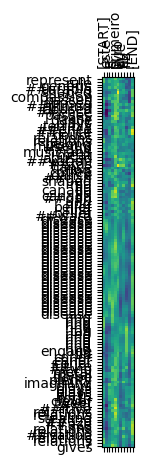

In [83]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [84]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

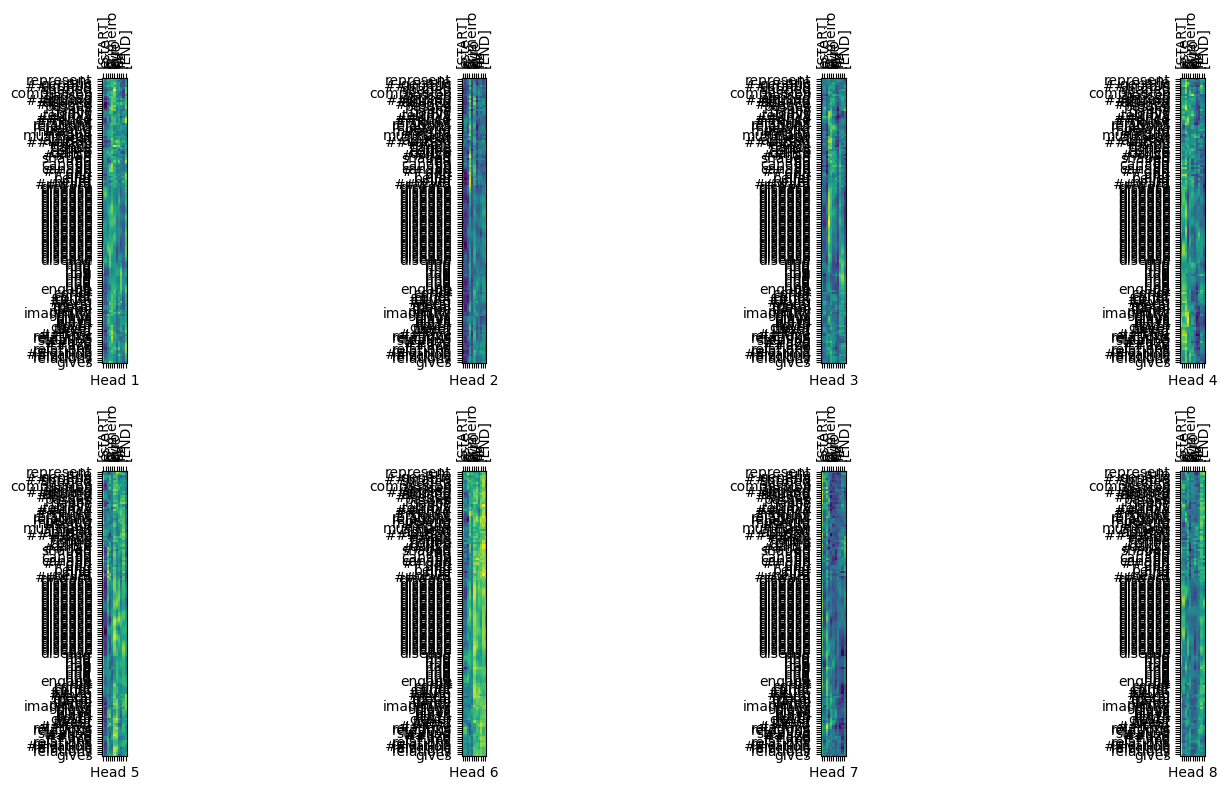

In [85]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/us

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : represent rule genericurableap abused sarajevo by abused output disease disease disease tightuing limited terriblyenceages fatherative belong belong museum museum museum museum museum abusedvation dance ring dancegan dancegan shaped photo retiredomical belong endless ring endless ring breathing shaped brought ringtion disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring ring tag ring ring ring ring ring engage flu conor conor conor futurevio metal metal skype reserve replacement methodnial relations future reserveaze shaped flunial relations relations stealingaze mo relations relations relationsvation relations relations 7 gives
Ground truth   : I read about triceratops in the encyclopedi

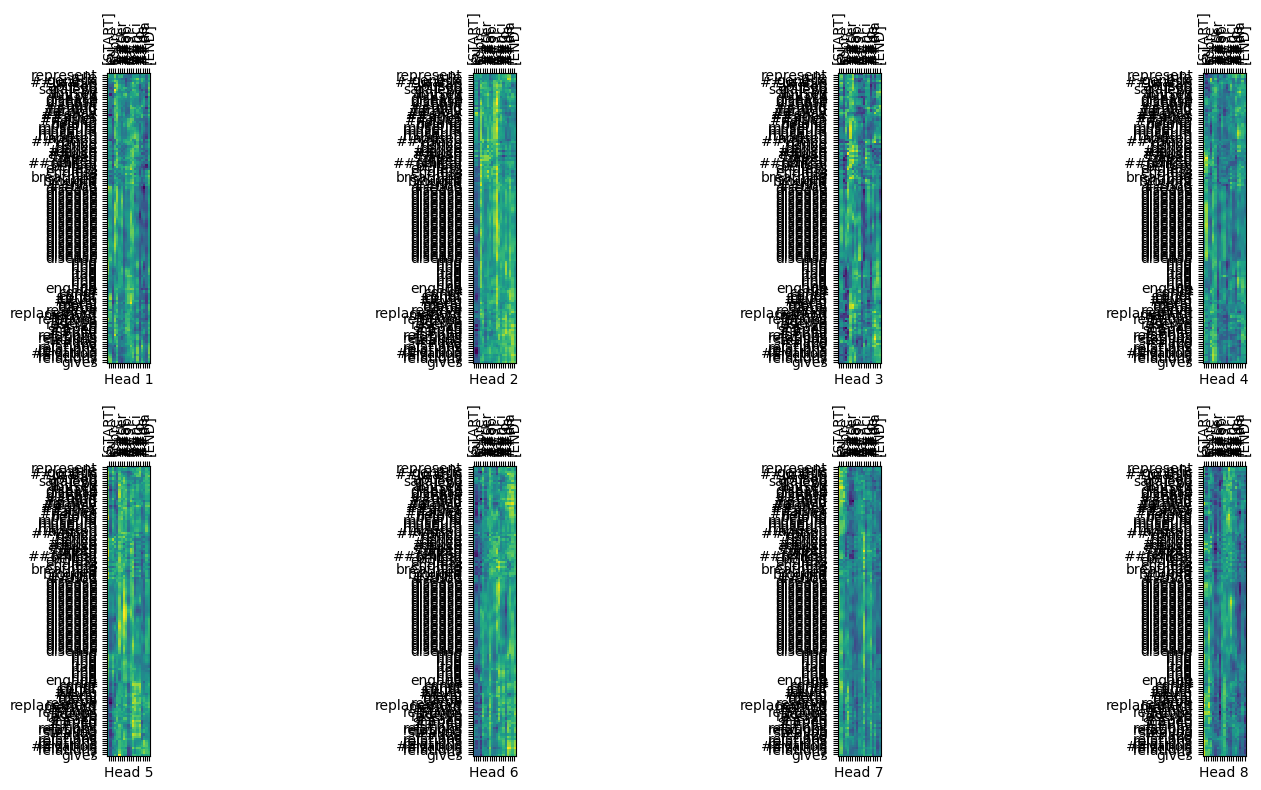

In [86]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

Export the model

In [87]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [88]:
translator = ExportTranslator(translator)

In [89]:
translator('este é o primeiro livro que eu fiz.').numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

b'represent rule genericurable shaped 3 compassion passes abusedinning abusedence passes any dance plays terriblyenceence doubt relations relations belong museumgan musicians meat abusedvationrds dance ring coffee dancegan shaped rna flu canada flu canadagan flu ring belief ring beliefward disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring tag ring ring ring ring ring ring engage flu conor conor conor futurevio metal metal skype plenty imagining plays plays plays plays forth clever tweetgitive relations relations stealingazeaze mo relations relationsvation relations relations 7 gives'

In [90]:
tf.saved_model.save(translator, export_dir='translator')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_7' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_6' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

In [91]:
reloaded = tf.saved_model.load('translator')

In [92]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'represent rule genericurable shaped 3 compassion passes abusedinning abusedence passes any dance plays terriblyenceence doubt relations relations belong museumgan musicians meat abusedvationrds dance ring coffee dancegan shaped rna flu canada flu canadagan flu ring belief ring beliefward disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease disease ring ring ring ring ring tag ring ring ring ring ring ring engage flu conor conor conor futurevio metal metal skype plenty imagining plays plays plays plays forth clever tweetgitive relations relations stealingazeaze mo relations relationsvation relations relations 7 gives'